In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


Remaining TODO:
- test problem template
- test variational rollout

# Problem templates

[G 0 0; G_1 G 0; G_2 0 G] 

Three terms: [U, U_1, U_2]

i d/dt U = H U
i d/dt [(dU/dv) / S] =  H [(dU/dv) / S] + [(dH/dv) / S] * U
...

**Constant coupling for drift**
dH(a(t); Δ)/dΔ = Z (Δ = 0)

**Direct control sensivity**
d/da1 H(a) = H_1

**Multiplicative error term (constant coupling)**
d/dc1 H(a) = a_1 H_1

**Additive error term**
H(a) = (a_1 + δa_1) H_1 (δa_1 = 0)
dH(a)/dδa1 = H_1

In [2]:
varsys = VariationalQuantumSystem(
    [PAULIS.X, PAULIS.Y],
    [PAULIS.X] # Make robust to these adjoint states
)

sys = QuantumSystem(
    [PAULIS.X, PAULIS.Y],
)

T = 50
Δt = 0.2

0.2

#### Sensitive

In [3]:
scale = 1.0
Q_s = 1e-2
prob3 = UnitaryVariationalProblem(
    varsys, GATES.X, T, Δt, 
    variational_scales=[scale], 
    R = 1e-2,
    dda_bound=1.0,
    Q_s=Q_s,
    sensitive_times=[[T],]
);
QuantumObjectives.unitary_fidelity_loss(prob3.trajectory.Ũ⃗ᵥ1[:, end])

    constructing UnitaryVariationalProblem...
	using integrator: typeof(VariationalUnitaryIntegrator)
	total variational parameters: 1
	robust knot points: [Int64[]]
	sensitive knot points: [[50]]
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt


4061.9117906796146

In [4]:
Q_s * scale^4 * QuantumObjectives.unitary_fidelity_loss(prob3.trajectory.Ũ⃗ᵥ1[:, end])

40.61911790679615

In [5]:
solve!(prob3, max_iter=200, print_level=5)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:    16270
Number of nonzeros in ine

In [6]:
QuantumObjectives.unitary_fidelity_loss(prob3.trajectory.Ũ⃗ᵥ1[:, end]) |> println
Q_s * scale^4 * QuantumObjectives.unitary_fidelity_loss(prob3.trajectory.Ũ⃗ᵥ1[:, end]) |> println

147074.88711622907
1470.7488711622907


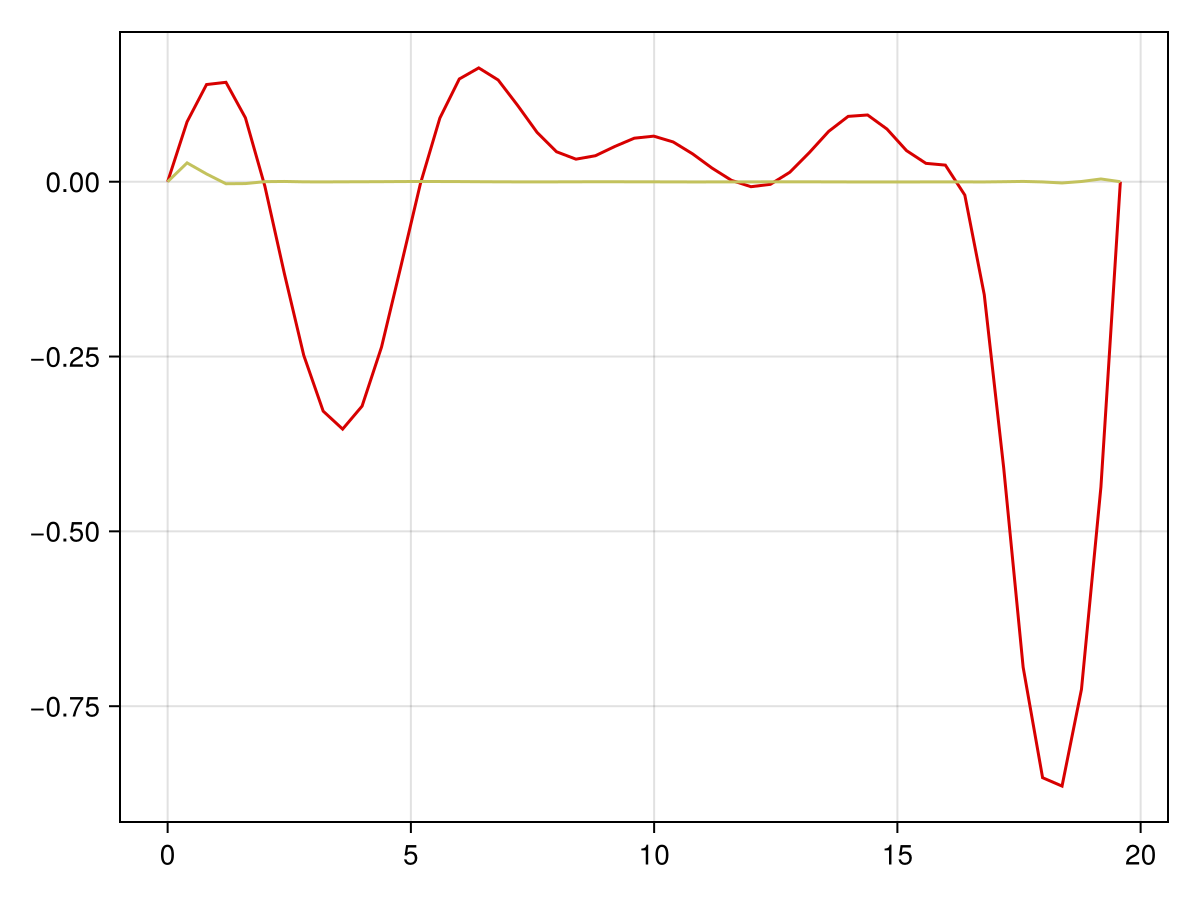

In [30]:
CairoMakie.plot(prob3.trajectory, :a)

In [8]:
Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(prob3.trajectory, varsys);
QuantumObjectives.unitary_fidelity_loss(Ũ⃗[:, end], GATES.X) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end ÷ 2]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end ÷ 2]) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end]) |> println

0.9987464865973747
8464.141392018593
147074.59369720652


#### Robust

In [9]:
scale = 1.0
# scale = 1 / 4.0
# scale = 1.0 / 8.0
Q_r = 1e2
prob = UnitaryVariationalProblem(
    varsys, GATES.X, T, Δt, 
    variational_scales=[scale], 
    Q_r=Q_r,
    robust_times=[[T]],)
QuantumObjectives.unitary_fidelity_loss(prob.trajectory.Ũ⃗ᵥ1[:, end]) |> println
Q_r * scale^4 * QuantumObjectives.unitary_fidelity_loss(prob.trajectory.Ũ⃗ᵥ1[:, end]) |> println

    constructing UnitaryVariationalProblem...
	using integrator: typeof(VariationalUnitaryIntegrator)
	total variational parameters: 1
	robust knot points: [[50]]
	sensitive knot points: [Int64[]]
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
620.819364927156
62081.9364927156


In [10]:
solve!(prob, max_iter=200, print_level=5)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:    16270
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2803

Total number of variables............................:     1130
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only upper bounds:        0
Total number of equality co

In [11]:
Q_r * scale^4 * QuantumObjectives.unitary_fidelity_loss(prob.trajectory.Ũ⃗ᵥ1[:, end])

0.00015310931762169851

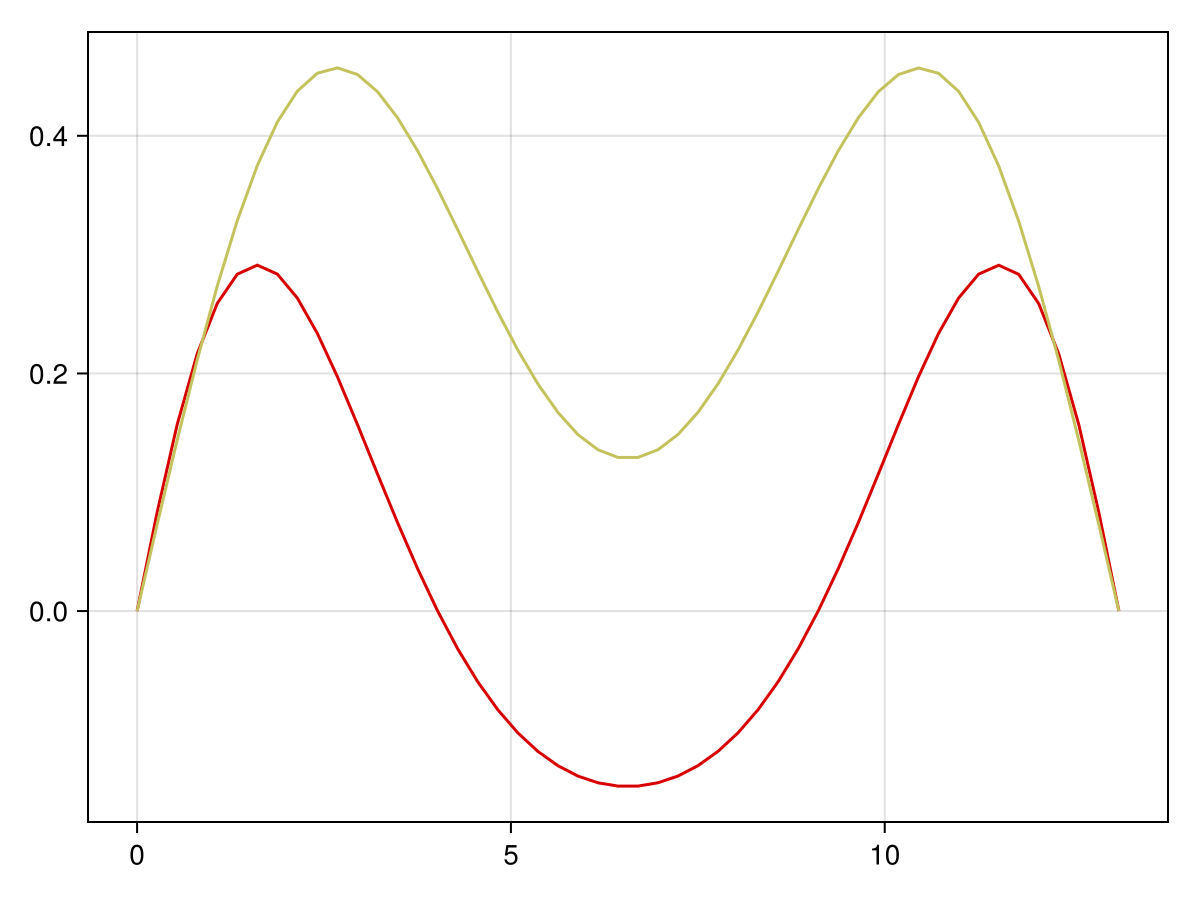

In [31]:
CairoMakie.plot(prob.trajectory, :a)

In [13]:
Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(prob.trajectory, varsys);
QuantumObjectives.unitary_fidelity_loss(Ũ⃗[:, end], GATES.X) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end ÷ 2]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end ÷ 2]) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end]) |> println

0.9999996972369609
53.37457593749453
1.531093176283143e-6


#### robust to multiplicative

In [34]:
varsys_mult = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    Function[a -> a[1] * PAULIS.X],
    2
)
# varsys_mult = VariationalQuantumSystem(
#     a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
#     [a -> a[1] * PAULIS.X],
#     2
# )

VariationalQuantumSystem: levels = 2, n_drives = 2

In [35]:
scale = 1.0
# scale = 1 / 4.0
# scale = 1.0 / 8.0
Q_r = 1e2
prob_mult = UnitaryVariationalProblem(
    varsys_mult, GATES.X, T, Δt, 
    variational_scales=[scale], 
    Q_r=Q_r,
    R=1.0,
    dda_bound=1.0,
    robust_times=[[T]],
)
QuantumObjectives.unitary_fidelity_loss(prob_mult.trajectory.Ũ⃗ᵥ1[:, end])

    constructing UnitaryVariationalProblem...
	using integrator: typeof(VariationalUnitaryIntegrator)
	total variational parameters: 1
	robust knot points: [[50]]
	sensitive knot points: [Int64[]]
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt


0.13746562766166198

In [36]:
solve!(prob_mult, max_iter=200, print_level=5)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:    16270
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2803

Total number of variables............................:     1130
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only upper bounds:        0
Total number of equality co

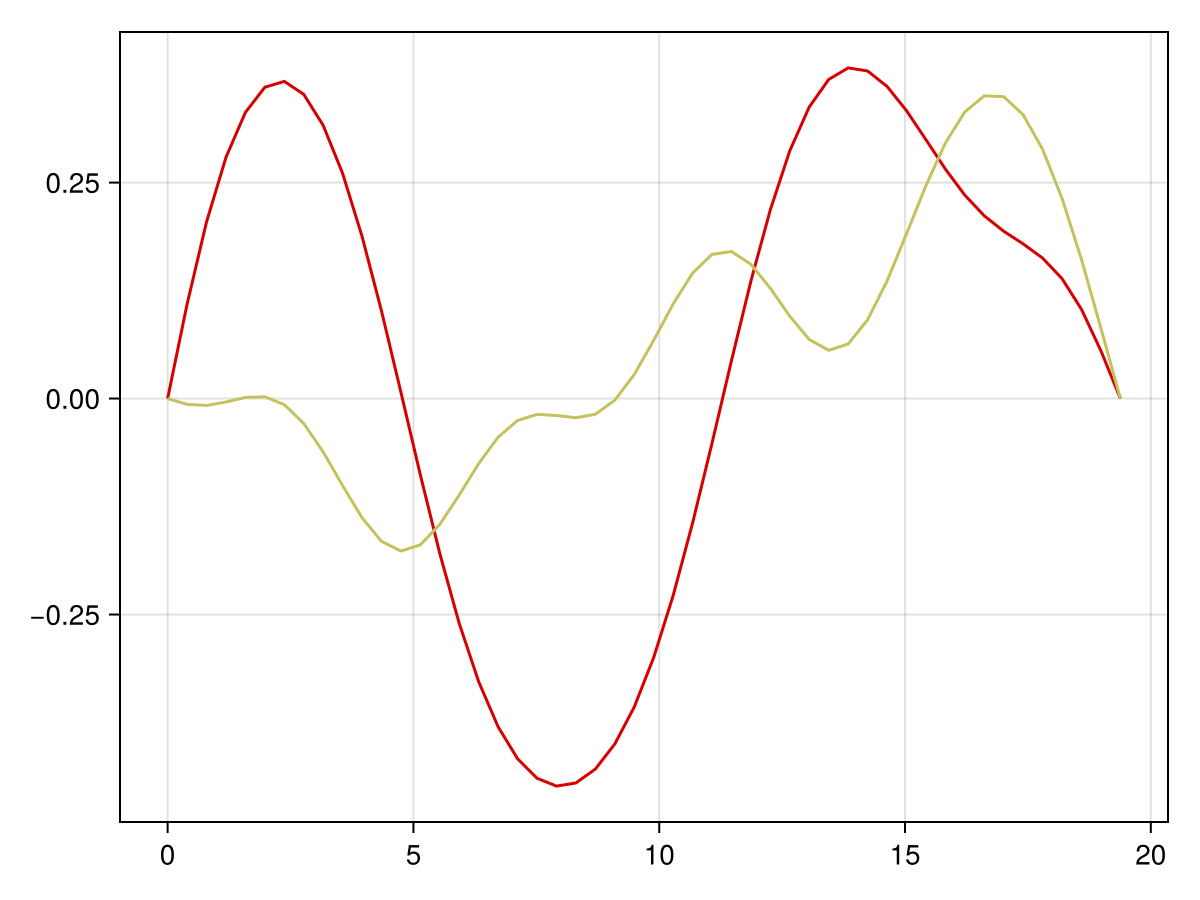

In [37]:
CairoMakie.plot(prob_mult.trajectory, :a)

In [38]:
Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(prob_mult.trajectory, varsys);
QuantumObjectives.unitary_fidelity_loss(Ũ⃗[:, end], GATES.X) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end ÷ 2]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end ÷ 2]) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end]) |> println

0.999998622998796
5714.152754083714
52626.51996090078


#### robust to both

In [19]:
varsys_both = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    [a -> a[1] * PAULIS.X, a -> PAULIS.X],
    2
)

VariationalQuantumSystem: levels = 2, n_drives = 2

In [20]:
scale = [1.0, 12.0]
# scale = 1 / 4.0
# scale = 1.0 / 8.0
Q_r = 1e2
prob_both = UnitaryVariationalProblem(
    varsys_both, GATES.X, T, Δt, 
    variational_scales=scale, 
    # Q_r=Q_r,
    # R=1.0,
    dda_bound=2.0,
    robust_times=[[T]],)
QuantumObjectives.unitary_fidelity_loss(prob_both.trajectory.Ũ⃗ᵥ1[:, end]) |> println
QuantumObjectives.unitary_fidelity_loss(prob_both.trajectory.Ũ⃗ᵥ2[:, end]) |> println

    constructing UnitaryVariationalProblem...
	using integrator: typeof(VariationalUnitaryIntegrator)
	total variational parameters: 2
	robust knot points: [[50]]
	sensitive knot points: [Int64[], Int64[]]
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
0.011892611281484767
0.10469337122220895


In [21]:
solve!(prob_both, max_iter=200, print_level=5)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: initial value of Ũ⃗ᵥ2
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:    33182
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2803

Total number of variables............................:     1522
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only

In [22]:
QuantumObjectives.unitary_fidelity_loss(prob_both.trajectory.Ũ⃗ᵥ1[:, end]) |> println
QuantumObjectives.unitary_fidelity_loss(prob_both.trajectory.Ũ⃗ᵥ2[:, end]) |> println

7.028143378076252e-7
0.43931600231361556


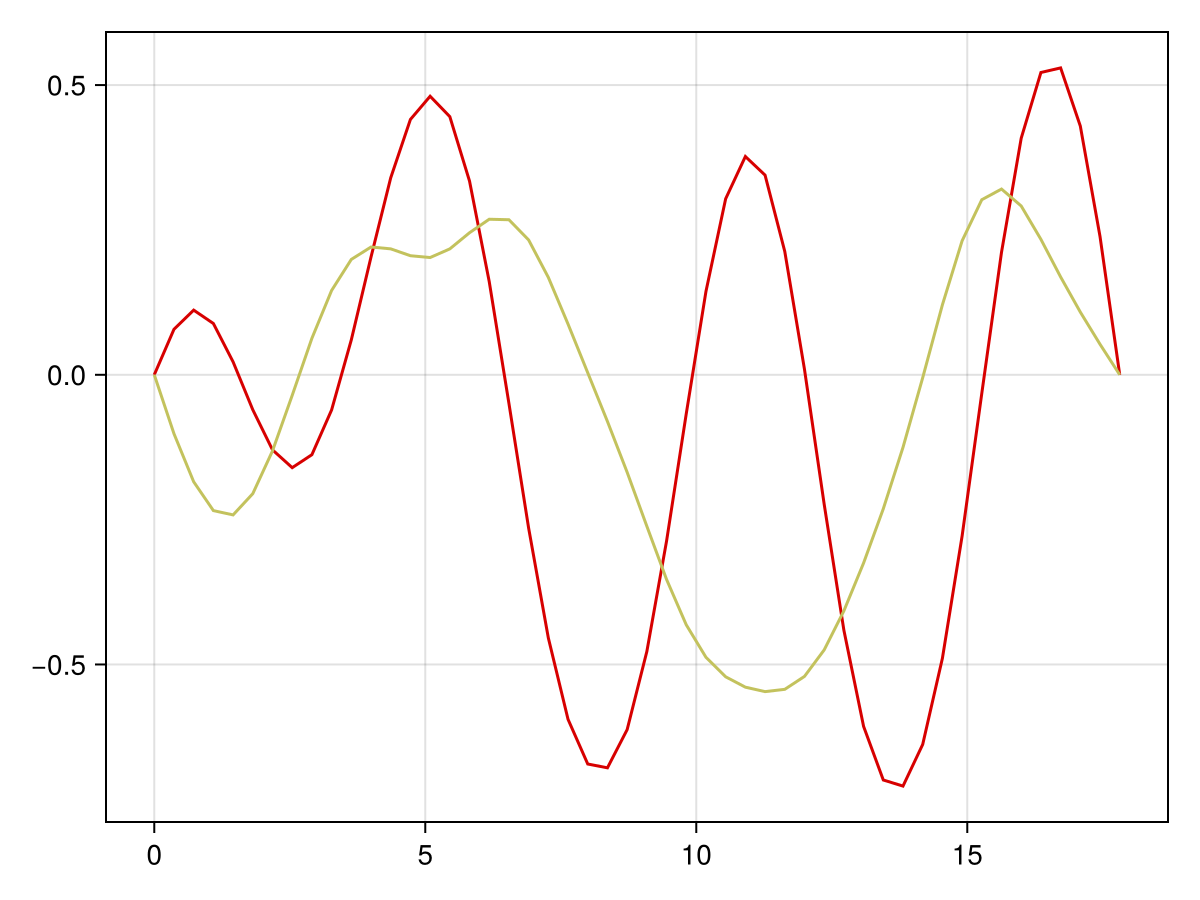

In [32]:
CairoMakie.plot(prob_both.trajectory, :a)

In [24]:
Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(prob_both.trajectory, varsys);
QuantumObjectives.unitary_fidelity_loss(Ũ⃗[:, end], GATES.X) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end ÷ 2]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end ÷ 2]) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end]) |> println

0.9999992010829167
3082.9834058787214
9109.655783147886


#### Smooth (default)

In [25]:
default = UnitarySmoothPulseProblem(sys, GATES.X, T, Δt)
solve!(default, max_iter=150, print_level=3)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
Total number of variables............................:      738
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only upper bounds:        0
Total number of equality constraints.................:      637
Total number of inequality constraints...............:        0
        inequality constraints with only

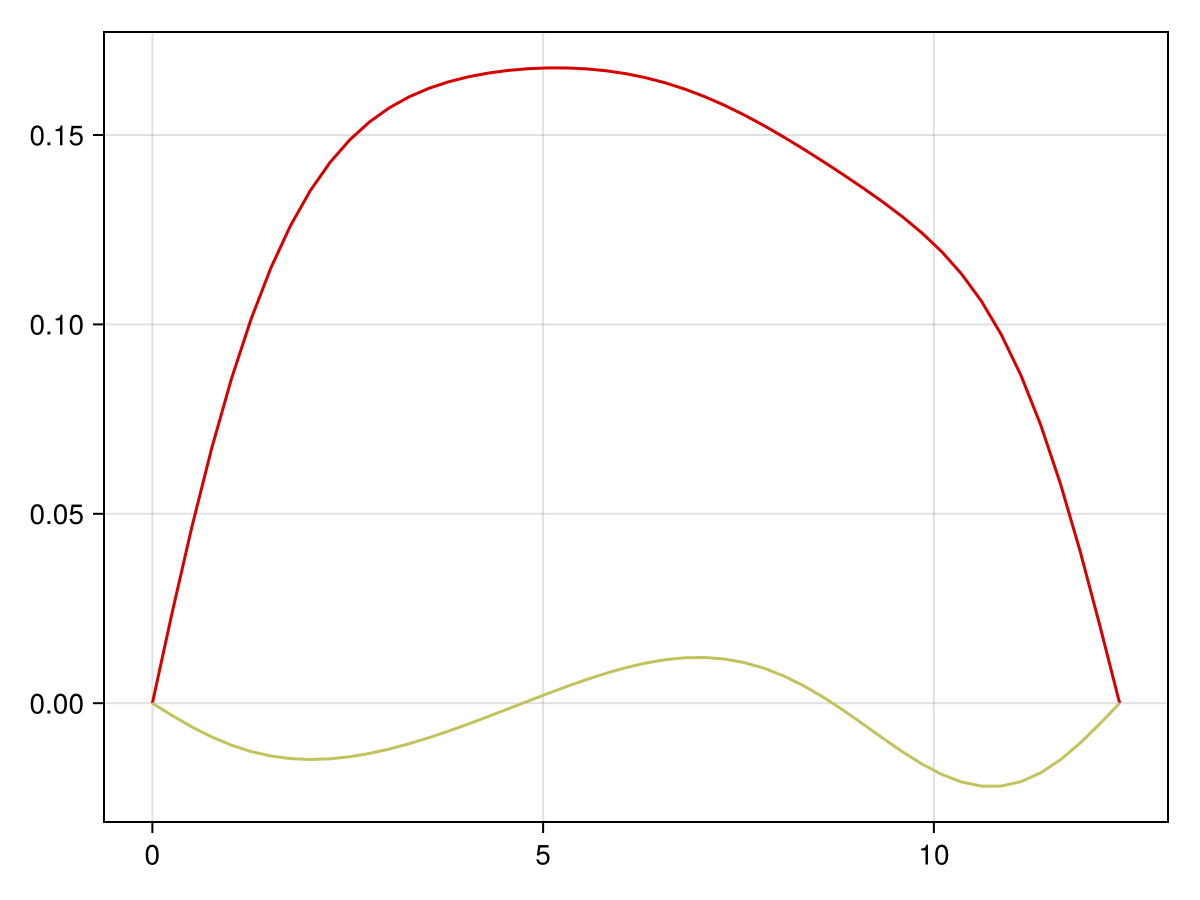

In [39]:
CairoMakie.plot(default.trajectory, :a)

In [27]:
Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(default.trajectory, varsys);
QuantumObjectives.unitary_fidelity_loss(Ũ⃗[:, end], GATES.X) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end ÷ 2]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end ÷ 2]) |> println
QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[1][:, end]) |> println
# QuantumObjectives.unitary_fidelity_loss(Ũ⃗_vars[2][:, end]) |> println

0.9999999260106007
1347.5588076350027
23404.393863181103


### Figures

In [28]:
# f = Figure()
# ax = Axis(f[1, 1])

# Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(prob3.trajectory, varsys)
# lines!(ax, [QuantumObjectives.unitary_fidelity_loss(x) for x in eachcol(Ũ⃗_vars[1])], label="sensitive")

# Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(prob.trajectory, varsys)
# lines!(ax, [QuantumObjectives.unitary_fidelity_loss(x) for x in eachcol(Ũ⃗_vars[1])], label="robust")

# Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(default.trajectory, varsys)
# lines!(ax, [QuantumObjectives.unitary_fidelity_loss(x) for x in eachcol(Ũ⃗_vars[1])], label="default")

# axislegend(ax, position=:lt)
# f

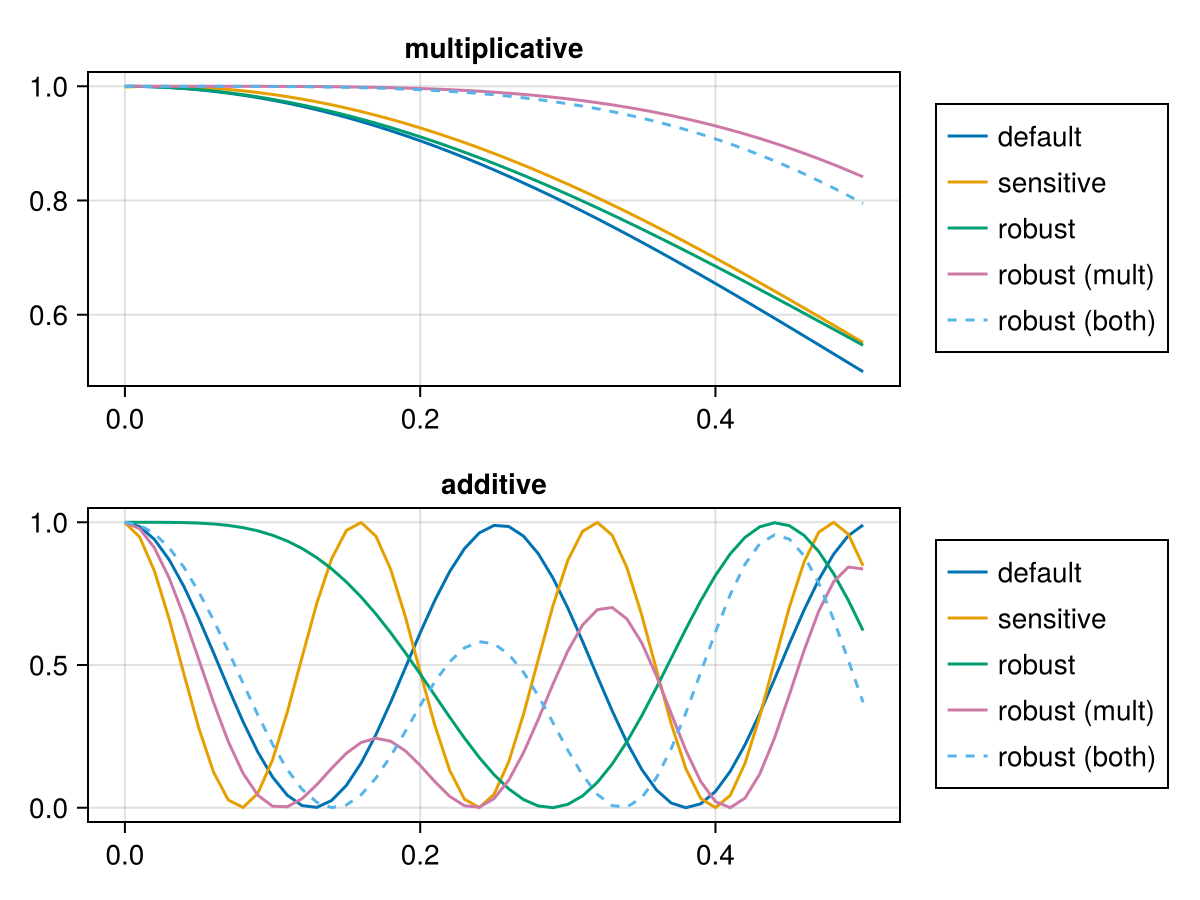

In [40]:
f = Figure()
ax1 = Axis(f[1, 1], title="multiplicative")
ax2 = Axis(f[2, 1], title="additive")

colors = Makie.wong_colors()

xs = 0:0.01:0.5

# Default

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem([(1 + x) * PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax1, xs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(x * PAULIS.X, [PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax2, xs, ys, label="default", color=colors[1], linestyle=:solid)

# Sensitive

ys = [unitary_rollout_fidelity(prob3.trajectory, QuantumSystem([(1 + x) * PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax1, xs, ys, label="sensitive", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(prob3.trajectory, QuantumSystem(x * PAULIS.X, [PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax2, xs, ys, label="sensitive", color=colors[2], linestyle=:solid)

# Robust 

ys = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem([(1 + x) * PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax1, xs, ys, label="robust", color=colors[3], linestyle=:solid)

ys = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem(x * PAULIS.X, [PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax2, xs, ys, label="robust", color=colors[3], linestyle=:solid)

# Robust (mult)
ys = [unitary_rollout_fidelity(prob_mult.trajectory, QuantumSystem([(1 + x) * PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax1, xs, ys, label="robust (mult)", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(prob_mult.trajectory, QuantumSystem(x * PAULIS.X, [PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax2, xs, ys, label="robust (mult)", color=colors[4], linestyle=:solid)

# Robust (both)
ys = [unitary_rollout_fidelity(prob_both.trajectory, QuantumSystem([(1 + x) * PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax1, xs, ys, label="robust (both)", color=colors[5], linestyle=:dash)

ys = [unitary_rollout_fidelity(prob_both.trajectory, QuantumSystem(x * PAULIS.X, [PAULIS.X, PAULIS.Y])) for x in xs]
lines!(ax2, xs, ys, label="robust (both)", color=colors[5], linestyle=:dash)


Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f